In [187]:
#importing dependancies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [188]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [189]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [190]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [191]:
# reflect an existing database into a new model
Base=automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [192]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [193]:
# Save references to each table
Station=Base.classes.station
Measurement=Base.classes.measurement

In [194]:
# Create our session (link) from Python to the DB
session=Session(engine)

In [195]:
#Viewing the columns in the table station
Station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [199]:
#Viewing the columns in the table measurement
Measurement.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

# Exploratory Precipitation Analysis

In [200]:
# Find the most recent date in the data set.
most_recent_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date[0])

2017-08-23


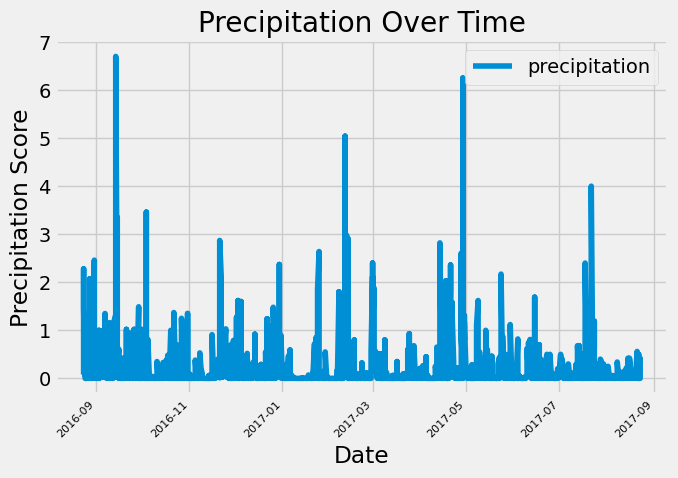

In [208]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

#Converting the most recent date from string to object
end_date_object=dt.datetime.strptime(most_recent_date[0], "%Y-%m-%d")

#extracting year and month inorder to find out year is leap or not
year = int(end_date_object.strftime('%Y'))
month = int(end_date_object.strftime('%m'))

# Calculate the date one year from the last date in data set.
if(year%4==0):
    start_date_object=end_date_object-dt.timedelta(days=366)

else:
    start_date_object=end_date_object-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>start_date_object,Measurement.prcp != None).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(data, columns=["date", "precipitation"])

# Sort the dataframe by date
df_sorted=df.sort_values(by="date")


df_sorted['date'] = pd.to_datetime(df_sorted['date'])  # Convert 'date' column to datetime
df_sorted.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df_sorted.plot(figsize=(7, 5))
plt.title('Precipitation Over Time')
plt.xlabel('Date')
plt.ylabel('Precipitation Score')

# Customizing x-axis ticks
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

In [161]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [162]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.station).count()

9

In [214]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_station=session.query(Measurement.station,func.count(Measurement.date)).group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).all()
for st in active_station:
    print(st.station, st[1])
    
    
#putting the above reuslt in dataframe for clarity and easy usage for furthur steps    
df_acs=pd.DataFrame(active_station,columns=["station","counts"])

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


STATION ID USC00519281 HAS GREATEST NUMBER OF OBSERVATIONS

In [215]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station==df_acs["station"][0]).all()

[(54.0, 85.0, 71.66378066378067)]

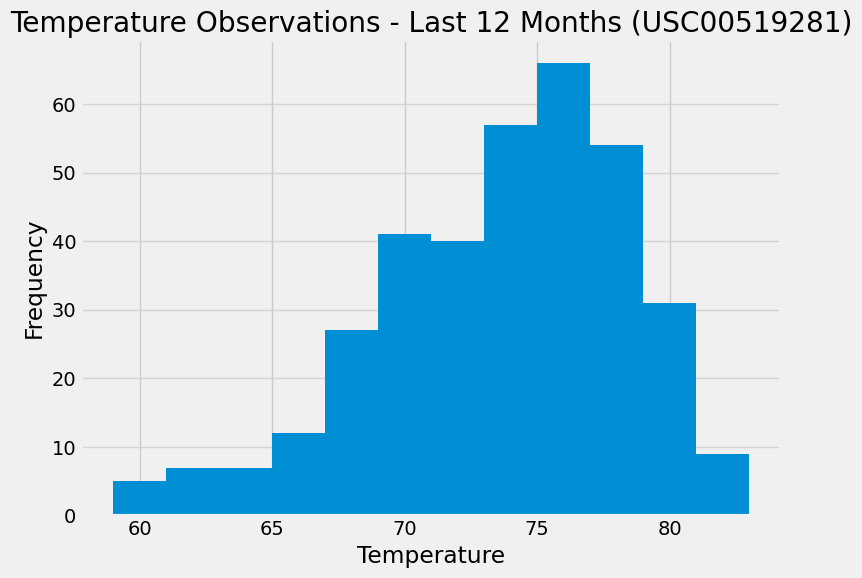

In [216]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query the last 12 months of temperature observation data for the most active station 
#all the dates will be referred with suffix _2 in the end, since now we are working only with station USC00519281
#and start date and end date relevant only to this station
#calculating the end date for observation for USC00519281
end_date_string_2=session.query(Measurement.date).filter(Measurement.station==df_acs["station"][0]).order_by(Measurement.date.desc()).first()
end_date_object_2=dt.datetime.strptime(end_date_string_2[0], "%Y-%m-%d")
year = int(end_date_object_2.strftime('%Y'))
month = int(end_date_object_2.strftime('%m'))

#extracting year and month inorder to find out year is leap or not
if(year%4==0):
    start_date_object_2=end_date_object_2-dt.timedelta(days=366)

else:
    start_date_object_2=end_date_object_2-dt.timedelta(days=365)
    

# Perform a query to retrieve the data and precipitation scores
data_2 = (
    session.query(Measurement.date, Measurement.tobs)
    .filter(Measurement.station == df_acs["station"][0], Measurement.date > start_date_object_2, Measurement.tobs != None)
    .order_by(Measurement.date)
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_2 = pd.DataFrame(data_2, columns=["date", "tobs"])

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(df_2['tobs'], bins=12)
plt.title(f'Temperature Observations - Last 12 Months ({df_acs["station"][0]})')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

# Close Session

In [217]:
# Close Session
session.close()